# Import packages

In [157]:
import os
import numpy as np
import pandas as pd
import re
import time 
# for matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import copy
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

- correlation
- filter
- if it works without 
- първа разлика прави данните стационарни
- directional simetry

In [8]:
# Define the paths
project_path = 'C:/Users/Viktor/Desktop/Summer School/Case_Drone_signature_classification/data/'
beebeerun_path = project_path + 'LOS/Test/UAV/BEEBEERUN/FLYING/'
dji_path = project_path + 'LOS/Test/UAV/DJI_MAVICPRO/HOVERING/'
output_dir = 'C:/Users/Viktor/Desktop/Summer School/Case_Drone_signature_classification/output/'

# Load the data

## Creation of the structured array

In [9]:
# Define the structured array with known column names and data types
data_types = [
    ('line_of_sight', 'U4'), 
    ('train_test', 'U5'), 
    ('device', 'U9'),
    ('make', 'U9'),
    ('model', 'U28'),
    ('activity', 'U8'),
    ('experiment', 'U2'),
    ('powers_fft', 'O'),]
structured_array = np.empty(0, dtype=data_types)

# Function to append a row to the structured array
def add_row_to_structured_array(struct_array, **kwargs):
    new_row = np.array([tuple(
        kwargs.get(name, None) for name in struct_array.dtype.names
        )], dtype=struct_array.dtype)
    return np.append(struct_array, new_row, axis=0)

# Function to fill the array using kwargs
def fill_array(structured_array, **kwargs):
    # Directly use kwargs to construct the data dictionary
    data_to_add = [kwargs]
    
    for data in data_to_add:
        structured_array = add_row_to_structured_array(structured_array, **data)
    
    return structured_array


print(structured_array.dtype.names)
print(len(structured_array))

# # Create boolean masks for each condition
# age_25_mask = structured_array['age'] == 25
# height_6_mask = structured_array['height'] == 6.0

# # Combine the masks using the bitwise AND operator
# combined_mask = age_25_mask & height_6_mask

# # Use the boolean mask to filter the structured array
# filtered_array = structured_array[combined_mask]

# print(filtered_array)

# print(structured_array['name'])
# print(structured_array[0])

('line_of_sight', 'train_test', 'device', 'make', 'model', 'activity', 'experiment', 'powers_fft')
0


## Dataset acquiring functions 

In [10]:
def get_all_metadata(filename, dirpath):
#     print(dirpath)
    file_path = os.path.join(dirpath, filename)

    # Get the make and the model
    make_model = os.path.basename(os.path.dirname(dirpath))
    make_model_split = make_model.split("_")
    make = make_model_split[0]
    if make == "BEEBEERUN":
        model = "FPV RC drone mini quadcopter"
    else:
        model = make_model_split[1]

    # Get the activity
    activity = os.path.basename(dirpath)
    # print('\tactivity:', activity)

    # Match the experiment and capture "meta" or "data"
    regex = r"_.*?(\d{1,2})\.mat_(meta|data)\.csv"
    match = re.search(regex, filename)
    if match:
        experiment = match.group(1)
        file_type = match.group(2)
    else:
        None
        # print("error",filename)

    # Get the device, line_of_sight and train_test
    device = os.path.basename(os.path.dirname(os.path.dirname(dirpath)))
    # print("\tdevice",device)

    # Get the line-of-sight and wether there is Train-Test split (True for Train)
    test_train = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(dirpath))))
    if test_train not in [ "Test", "Train"]:
        # we are in NLOS
        line_of_sight = test_train
        test_train = "none"
    else:
        line_of_sight = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(dirpath)))))

    # print("\tline_of_sight", line_of_sight)
    # print("\ttest_train", test_train)
    
    # print("\texperiment", type(experiment), "  |  ",file_type)
    return file_type, make, model, activity, experiment, line_of_sight, test_train, device


def load_data(path, nth_value_only=False):

    # Load the CSV file using numpy, only reading the "Data" column
    data = np.genfromtxt(path, delimiter=',', skip_header=1, usecols=[0], dtype=float)
    # Scale to get voltage
    data = data * 6.581**(-6)

    if nth_value_only:
        data = data[::nth_value_only]

    return data


def process_signal(input_data):
    # Calculate the Fourier Transform
    fft = np.fft.fft(input_data)
    
    # Calculate Power Spectral Density (PSD)
    freqs = np.fft.fftfreq(len(input_data))
    psd = np.abs(fft)**2 / len(input_data)

    # Limit the Power Spectral Density to frequencies from 0 to 0.5 (needed for alignment between all datasets)
    positive_psd = psd[(freqs >= 0) & (freqs <= 0.5)]
    positive_freqs = freqs[(freqs >= 0) & (freqs <= 0.5)]

    return positive_psd, positive_freqs


def iterate_folders(root_dir, structured_array, nth_value_only):
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.csv'):

                file_type, make, model, activity, experiment, line_of_sight, train_test, device = get_all_metadata(filename, dirpath)

                if file_type == "data":
                    # The actual data

                    print(dirpath)
                    print(f'train_test: {train_test}  |  make: {make}  |  model: {model}  |  activity: {activity}  |  experiment: {experiment}')
                    
                    tic = time.time()
                    # Load the signal
                    signal = load_data(dirpath + "/" + filename, nth_value_only)
                    # print(len(signal))

                    ############## FOURIER TRANSFORM ##############
                    powers_fft = process_signal(signal)
                    print('\tFFT is ready, power spectrum len:', len(powers_fft))
                    ###############################################

                    tac = time.time()
                    execution_time = tac - tic
                    print(f"\tExecution time: {execution_time:.4f} seconds")

                else:
                    # The metadata
                    continue

                    # ###############
                    # NOT NEEDED!!!
                    # add code to extract the metadata in some variables
                    # df = pd.read_csv(dirpath + "/" + filename)
                    # # Append the DataFrame to the list
                    # data_frames.append(df)
                    # ###############
                
                ################
                # add code to append all variables to the structured array
                structured_array = fill_array(
                structured_array, 
                line_of_sight = line_of_sight, 
                train_test = train_test, 
                device = device, 
                make = make, 
                model = model, 
                activity = activity, 
                experiment = experiment, 
                powers_fft = powers_fft
                )
                ################

                print(f"\tNow we have {len(structured_array)} samples")
                print()

    # all_data_df = pd.concat(data_frames, ignore_index=True)

    return structured_array

## Run to get the whole dataset 

In [11]:
# Get the current working directory
current_directory = os.getcwd()

# Assuming the CardRF directory is in the same folder as the current script
cardrf_directory = os.path.join(current_directory, 'data')

# Load the data
nth_value_only = False

data_array = iterate_folders(cardrf_directory, structured_array, nth_value_only)


c:\Users\Viktor\Desktop\Summer School\Case_Drone_signature_classification\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 02
	FFT is ready, power spectrum len: 2500000
	Execution time: 10.3704 seconds
	Now we have 1 samples

c:\Users\Viktor\Desktop\Summer School\Case_Drone_signature_classification\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 04
	FFT is ready, power spectrum len: 2500000
	Execution time: 10.0199 seconds
	Now we have 2 samples

c:\Users\Viktor\Desktop\Summer School\Case_Drone_signature_classification\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 06
	FFT is ready, power spectrum len: 2500000
	Execution time: 9.4768 seconds
	Now we have 3 samples

c:\Users\Viktor\Desktop

In [24]:
len(data_array['powers_fft'][5]) 
num_values = 2500000 # number of samples of the signal / 2
freqs_array = np.linspace(0, 0.5, num_values)

In [27]:
data_array[5]

('LOS', 'Test', 'UAV', 'DJI', 'INSPIRE', 'FLYING', '01', array([6.98171992e+02, 3.38876492e-04, 5.43621867e-04, ...,
       7.10197542e-07, 1.01170111e-06, 1.17681374e-06]))

In [29]:
peaks

,0.0-4e-07 Hz,4e-07-0.001 Hz,0.034-0.038 Hz,0.1205-0.1211 Hz,0.1211-0.1215 Hz,0.1215-0.1225 Hz,0.123-0.1236 Hz,0.24-0.245 Hz,0.275-0.28 Hz,0.475-0.49 Hz
0,NaN,NaN,NaN,436.469452,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
len(data_array)
data_array

array([('LOS', 'Test', 'UAV', 'BEEBEERUN', 'FPV RC drone mini quadcopter', 'FLYING', '02', array([2.55821904e+02, 8.58800217e+02, 2.71634834e-01, ...,
              2.71086080e-04, 2.56967061e-06, 2.95203539e-03]))                                                                                       ,
       ('LOS', 'Test', 'UAV', 'BEEBEERUN', 'FPV RC drone mini quadcopter', 'FLYING', '04', array([2.51944055e+02, 8.55152462e+02, 2.60921620e-01, ...,
              3.75287415e-04, 1.25690990e-06, 2.94832595e-03]))                                                                                       ,
       ('LOS', 'Test', 'UAV', 'BEEBEERUN', 'FPV RC drone mini quadcopter', 'FLYING', '06', array([2.48975614e+02, 8.51956151e+02, 2.79154982e-01, ...,
              3.01524815e-04, 9.06745625e-08, 2.74941806e-03]))                                                                                       ,
       ('LOS', 'Test', 'UAV', 'BEEBEERUN', 'FPV RC drone mini quadcopter', 'FLYING', '09', 

# Get range of the peaks

In [30]:
working_array = copy.deepcopy(data_array)

In [35]:
def col_value_counts(array_col):
        
    col = array_col
    col_count = Counter(col)

    # Convert the result to a dictionary or a pandas DataFrame for better readability
    df = pd.DataFrame.from_dict(col_count, orient='index', columns=['count'])

    # display(df)
    return df

## Make new columns

In [48]:
# Create the new column by concatenating 'make', 'model', and 'activity'
make_model_activity = np.array([f"{row['make']} - {row['model']} - {row['activity']}" for row in working_array])


# Add the new column to the structured array
new_dtype = working_array.dtype.descr + [('make_model_activity', 'U100')]
new_data = np.zeros(working_array.shape, dtype=new_dtype)

for name in working_array.dtype.names:
    new_data[name] = working_array[name]

new_data['make_model_activity'] = make_model_activity

new_data.dtype.names

('line_of_sight',
 'train_test',
 'device',
 'make',
 'model',
 'activity',
 'experiment',
 'powers_fft',
 'make_model_activity')

In [65]:
make_model

array(['BEEBEERUN - FPV RC drone mini quadcopter',
       'BEEBEERUN - FPV RC drone mini quadcopter',
       'BEEBEERUN - FPV RC drone mini quadcopter',
       'BEEBEERUN - FPV RC drone mini quadcopter',
       'BEEBEERUN - FPV RC drone mini quadcopter', 'DJI - INSPIRE',
       'DJI - INSPIRE', 'DJI - INSPIRE', 'DJI - INSPIRE', 'DJI - INSPIRE',
       'DJI - INSPIRE', 'DJI - INSPIRE', 'DJI - INSPIRE', 'DJI - INSPIRE',
       'DJI - INSPIRE', 'DJI - M600', 'DJI - M600', 'DJI - M600',
       'DJI - M600', 'DJI - M600', 'DJI - MAVICPRO', 'DJI - MAVICPRO',
       'DJI - MAVICPRO', 'DJI - MAVICPRO', 'DJI - MAVICPRO',
       'DJI - MAVICPRO', 'DJI - MAVICPRO', 'DJI - MAVICPRO',
       'DJI - MAVICPRO', 'DJI - MAVICPRO', 'DJI - PHANTOM',
       'DJI - PHANTOM', 'DJI - PHANTOM', 'DJI - PHANTOM', 'DJI - PHANTOM',
       'DJI - PHANTOM', 'DJI - PHANTOM', 'DJI - PHANTOM', 'DJI - PHANTOM',
       'DJI - PHANTOM', 'BEEBEERUN - FPV RC drone mini quadcopter',
       'BEEBEERUN - FPV RC drone mini qua

In [52]:
# Create the new column by concatenating 'make' and 'model'
make_model = np.array([f"{row['make']} - {row['model']}" for row in new_data])


# Add the new column to the structured array
new_dtype = working_array.dtype.descr + [('make_model', 'U100')]
new_data = np.zeros(working_array.shape, dtype=new_dtype)

for name in working_array.dtype.names:
    new_data[name] = working_array[name]

new_data['make_model'] = make_model

new_data.dtype.names

('line_of_sight',
 'train_test',
 'device',
 'make',
 'model',
 'activity',
 'experiment',
 'powers_fft',
 'make_model')

In [54]:
# df = col_value_counts(new_data['make_model_activity'])
df = col_value_counts(new_data['make_model'])
df

,count
BEEBEERUN - FPV RC drone mini quadcopter,25
DJI - INSPIRE,70
DJI - M600,45
DJI - MAVICPRO,50
DJI - PHANTOM,70


## Plots of the peaks

In [ ]:
# Plot multiple examples of one make_model_activity

# df = col_value_counts(new_data['make_model_activity'])
df = col_value_counts(new_data['make_model'])

def plot_all_psd_one_type(powers_fft_arrays, titles):
    # range: 
    left = 0
    right = 0.5


    plt.figure(figsize=(10, 6))

    for power_spectrum in powers_fft_arrays:
        freqs_range = freqs_array[(freqs_array >= left) & (freqs_array <= right)]
        psd_range = power_spectrum[(freqs_array >= left) & (freqs_array <= right)]

        # Plot the periodogram with only positive frequencies
        plt.plot(freqs_range, psd_range, label='Signal', color='blue')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title(f'Periodogram of the Signal\n{titles} ({len(powers_fft_arrays)} samples)')
    plt.grid(True)
    plt.show()

for ind in df.index:
    print(ind)

    # mask = new_data['make_model_activity'] == ind
    mask = new_data['make_model'] == ind
    the_array = new_data[mask]
    powers_fft_arrays = the_array['powers_fft']

    plot_all_psd_one_type(powers_fft_arrays, ind)

## Exctract peaks

In [60]:
# Generate frequency array
num_values = 2500000 # number of samples of the signal / 2
freqs_array = np.linspace(0, 0.5, num_values)

def extract_peaks(freqs, psd, height=15, prom=15, column_names=None, freq_ranges=None):

    # Default frequency ranges if not provided
    if freq_ranges is None:
        freq_ranges = [
            (0.0000000, 0.0000004), (0.0000004, 0.0010000), (0.0340, 0.0380), 
            (0.1205, 0.1211), (0.1211, 0.1215), (0.1215, 0.1225), 
            (0.1230, 0.1236), (0.240, 0.245), (0.275, 0.280), (0.475, 0.490)
        ]

    # Default column names if not provided
    if column_names is None:
        column_names = [
            f"{low}-{high} Hz" for low, high in freq_ranges
        ]

    # Initialize list to store peak PSD values
    new_arrays = []

    # Loop through each frequency range to find peaks
    for (low, high) in freq_ranges:
        mask = (freqs >= low) & (freqs <= high)
        positive_psd = psd[mask]
        peaks, _ = find_peaks(positive_psd, height=height, prominence=prom)

        # Append maximum peak value or NaN if no peaks are found
        if peaks.size == 0:
            new_arrays.append(0)
        else:
            new_arrays.append(np.max(positive_psd[peaks]))

    # # Create a DataFrame with the maximum powers for each frequency as columns
    # peaks_df = pd.DataFrame(new_arrays).T
    # peaks_df.columns = column_names

    return new_arrays

peaks = extract_peaks(
    freqs_array, 
    new_data['powers_fft'][5], 
    column_names = ["0.0002 mHz","0.5002 mHz","36.0 mHz","120.8 mHz","121.3 mHz","122.0 mHz","123.3 mHz","242.5 mHz","277.5 mHz","482.5 mHz"])

peaks
                                             

[0, 0, 0, 436.4694515596972, 0, 0, 0, 0, 0, 0]

In [74]:
# Convert the structured array to a Pandas DataFrame
working_df = pd.DataFrame(new_data)
working_df

,line_of_sight,train_test,device,make,model,activity,experiment,powers_fft,make_model
0,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,02,"[255.82190409563194, 858.8002174242329, 0.2716...",BEEBEERUN - FPV RC drone mini quadcopter
1,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,04,"[251.94405452913398, 855.1524619232008, 0.2609...",BEEBEERUN - FPV RC drone mini quadcopter
2,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,06,"[248.97561355314008, 851.9561513585492, 0.2791...",BEEBEERUN - FPV RC drone mini quadcopter
3,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,09,"[246.37686397091719, 847.5399604320223, 0.2508...",BEEBEERUN - FPV RC drone mini quadcopter
4,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,12,"[241.7988476679791, 843.5645838494625, 0.30257...",BEEBEERUN - FPV RC drone mini quadcopter
...,...,...,...,...,...,...,...,...,...
255,NLOS,none,UAV,DJI,PHANTOM,FLYING,16,"[906.006398803741, 0.00032418492153497104, 0.0...",DJI - PHANTOM
256,NLOS,none,UAV,DJI,PHANTOM,FLYING,17,"[893.1328965276092, 0.0002507727758290135, 0.0...",DJI - PHANTOM
257,NLOS,none,UAV,DJI,PHANTOM,FLYING,18,"[890.192098740478, 0.0015453122313219866, 0.00...",DJI - PHANTOM
258,NLOS,none,UAV,DJI,PHANTOM,FLYING,19,"[893.3265839394014, 0.0009329605834082333, 0.0...",DJI - PHANTOM


### Apply the function

In [76]:
# Define frequency array
num_values = 2500000 # number of samples of the signal / 2
freqs_array = np.linspace(0, 0.5, num_values)

working_df['peaks_pds'] = working_df['powers_fft'].copy()
working_df['peaks_pds'] = working_df['peaks_pds'].apply(lambda x: extract_peaks(freqs_array, x))
working_df

,line_of_sight,train_test,device,make,model,activity,experiment,powers_fft,make_model,peaks_pds
0,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,02,"[255.82190409563194, 858.8002174242329, 0.2716...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 97.85561378305802, 45.44610688717509, 186...."
1,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,04,"[251.94405452913398, 855.1524619232008, 0.2609...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 98.2364516433497, 53.93841150301101, 184.0..."
2,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,06,"[248.97561355314008, 851.9561513585492, 0.2791...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 97.62557465114187, 52.710984899519524, 178..."
3,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,09,"[246.37686397091719, 847.5399604320223, 0.2508...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 96.85092298596616, 49.696471221708855, 176..."
4,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,12,"[241.7988476679791, 843.5645838494625, 0.30257...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 96.3284032667124, 43.766368661897765, 175...."
...,...,...,...,...,...,...,...,...,...,...
255,NLOS,none,UAV,DJI,PHANTOM,FLYING,16,"[906.006398803741, 0.00032418492153497104, 0.0...",DJI - PHANTOM,"[0, 0, 0, 22.24985758270408, 0, 0, 0, 0, 0, 0]"
256,NLOS,none,UAV,DJI,PHANTOM,FLYING,17,"[893.1328965276092, 0.0002507727758290135, 0.0...",DJI - PHANTOM,"[0, 0, 0, 0, 0, 0, 54.22060475038606, 0, 0, 0]"
257,NLOS,none,UAV,DJI,PHANTOM,FLYING,18,"[890.192098740478, 0.0015453122313219866, 0.00...",DJI - PHANTOM,"[0, 0, 0, 0, 0, 0, 33.7137991475708, 0, 0, 0]"
258,NLOS,none,UAV,DJI,PHANTOM,FLYING,19,"[893.3265839394014, 0.0009329605834082333, 0.0...",DJI - PHANTOM,"[0, 0, 0, 0, 0, 0, 18.828554527677554, 0, 0, 0]"


In [143]:
# Add new column
working_df['make_model_activity'] = working_df['make_model'] + " - " +  working_df['activity']
working_df

,line_of_sight,train_test,device,make,model,activity,experiment,powers_fft,make_model,peaks_pds,make_model_activity
0,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,02,"[255.82190409563194, 858.8002174242329, 0.2716...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 97.85561378305802, 45.44610688717509, 186....",BEEBEERUN - FPV RC drone mini quadcopter - FLYING
1,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,04,"[251.94405452913398, 855.1524619232008, 0.2609...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 98.2364516433497, 53.93841150301101, 184.0...",BEEBEERUN - FPV RC drone mini quadcopter - FLYING
2,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,06,"[248.97561355314008, 851.9561513585492, 0.2791...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 97.62557465114187, 52.710984899519524, 178...",BEEBEERUN - FPV RC drone mini quadcopter - FLYING
3,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,09,"[246.37686397091719, 847.5399604320223, 0.2508...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 96.85092298596616, 49.696471221708855, 176...",BEEBEERUN - FPV RC drone mini quadcopter - FLYING
4,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,12,"[241.7988476679791, 843.5645838494625, 0.30257...",BEEBEERUN - FPV RC drone mini quadcopter,"[0, 96.3284032667124, 43.766368661897765, 175....",BEEBEERUN - FPV RC drone mini quadcopter - FLYING
...,...,...,...,...,...,...,...,...,...,...,...
255,NLOS,none,UAV,DJI,PHANTOM,FLYING,16,"[906.006398803741, 0.00032418492153497104, 0.0...",DJI - PHANTOM,"[0, 0, 0, 22.24985758270408, 0, 0, 0, 0, 0, 0]",DJI - PHANTOM - FLYING
256,NLOS,none,UAV,DJI,PHANTOM,FLYING,17,"[893.1328965276092, 0.0002507727758290135, 0.0...",DJI - PHANTOM,"[0, 0, 0, 0, 0, 0, 54.22060475038606, 0, 0, 0]",DJI - PHANTOM - FLYING
257,NLOS,none,UAV,DJI,PHANTOM,FLYING,18,"[890.192098740478, 0.0015453122313219866, 0.00...",DJI - PHANTOM,"[0, 0, 0, 0, 0, 0, 33.7137991475708, 0, 0, 0]",DJI - PHANTOM - FLYING
258,NLOS,none,UAV,DJI,PHANTOM,FLYING,19,"[893.3265839394014, 0.0009329605834082333, 0.0...",DJI - PHANTOM,"[0, 0, 0, 0, 0, 0, 18.828554527677554, 0, 0, 0]",DJI - PHANTOM - FLYING


In [156]:
# Print out values for presentation purposes
value_counts = working_df[['make', 'model', 'activity']].value_counts()

# Convert the result to a DataFrame to enable sorting
value_counts_df = value_counts.reset_index(name='counts')

# Sort the DataFrame by the 'make' column
sorted_value_counts_df = value_counts_df.sort_values(by=['make', 'model'])

# Display the sorted DataFrame
sorted_value_counts_df

,make,model,activity,counts
3,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,25
0,DJI,INSPIRE,FLYING,45
4,DJI,INSPIRE,VIDEOING,25
1,DJI,M600,FLYING,45
5,DJI,MAVICPRO,FLYING,25
6,DJI,MAVICPRO,HOVERING,25
2,DJI,PHANTOM,FLYING,45
7,DJI,PHANTOM,HOVERING,25


### Save the dataset

In [145]:
working_df.to_pickle("naughty_drones_dataset")

### Plot the extracted peaks

make_model_activity
DJI - INSPIRE - FLYING                               45
DJI - M600 - FLYING                                  45
DJI - PHANTOM - FLYING                               45
BEEBEERUN - FPV RC drone mini quadcopter - FLYING    25
DJI - INSPIRE - VIDEOING                             25
DJI - MAVICPRO - FLYING                              25
DJI - MAVICPRO - HOVERING                            25
DJI - PHANTOM - HOVERING                             25
Name: count, dtype: int64
peaks of DJI - INSPIRE - FLYING


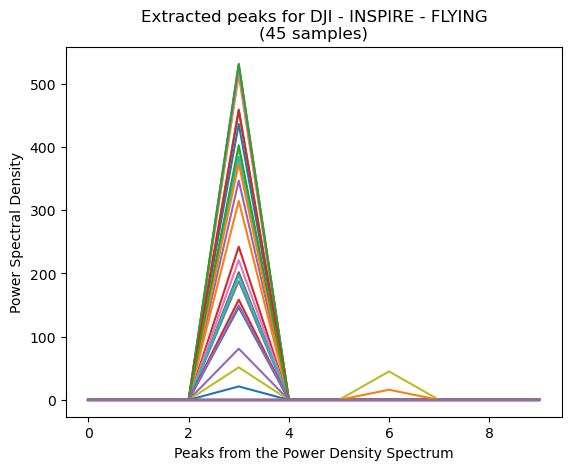

peaks of DJI - M600 - FLYING


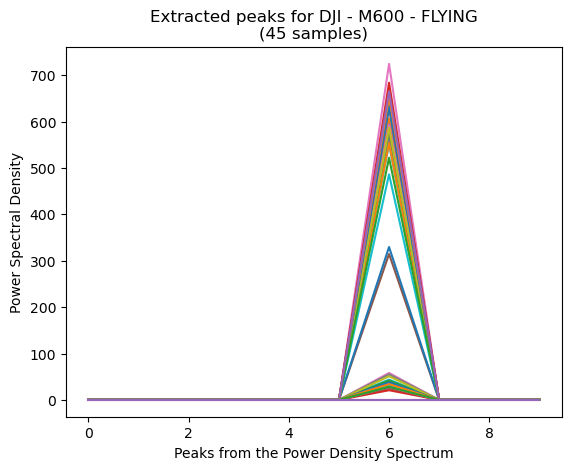

peaks of DJI - PHANTOM - FLYING


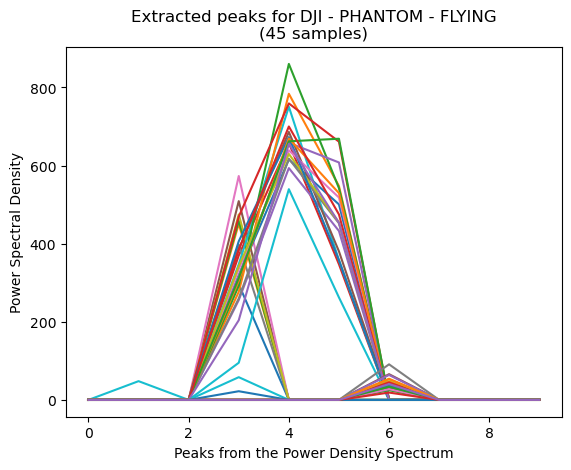

peaks of BEEBEERUN - FPV RC drone mini quadcopter - FLYING


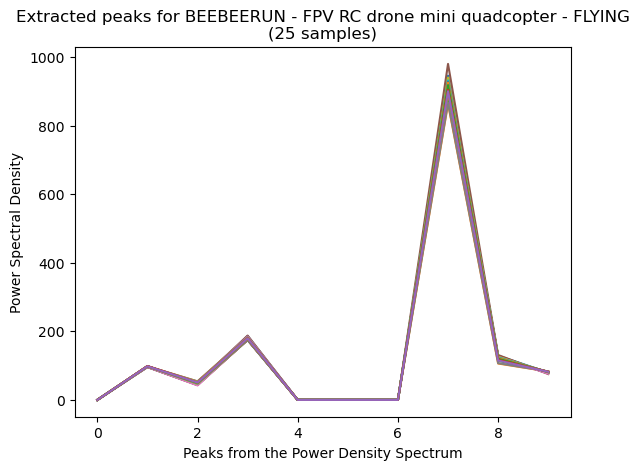

peaks of DJI - INSPIRE - VIDEOING


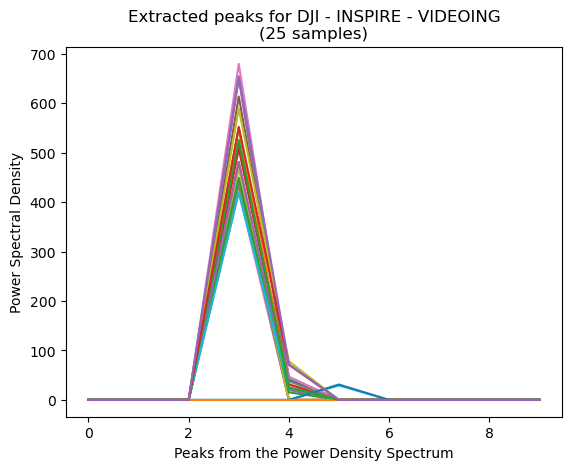

peaks of DJI - MAVICPRO - FLYING


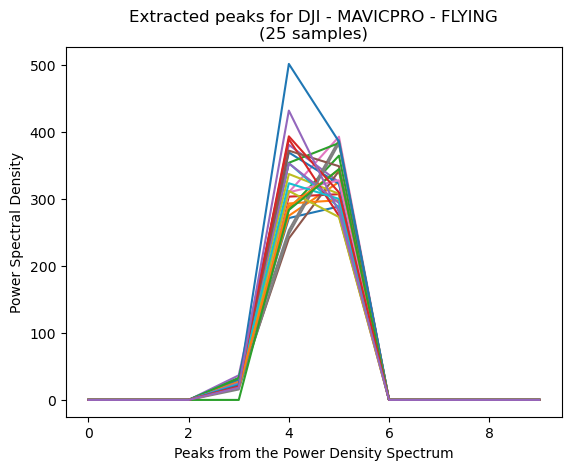

peaks of DJI - MAVICPRO - HOVERING


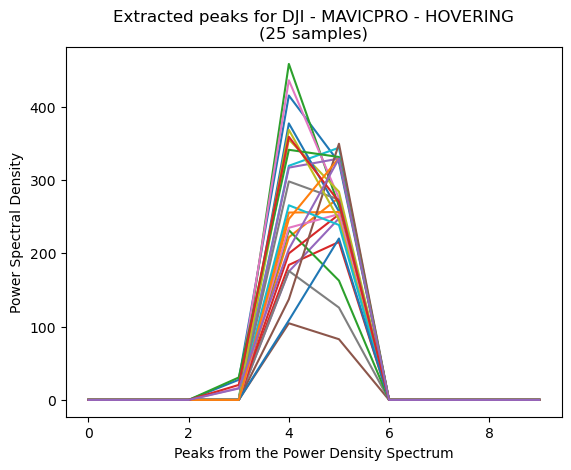

peaks of DJI - PHANTOM - HOVERING


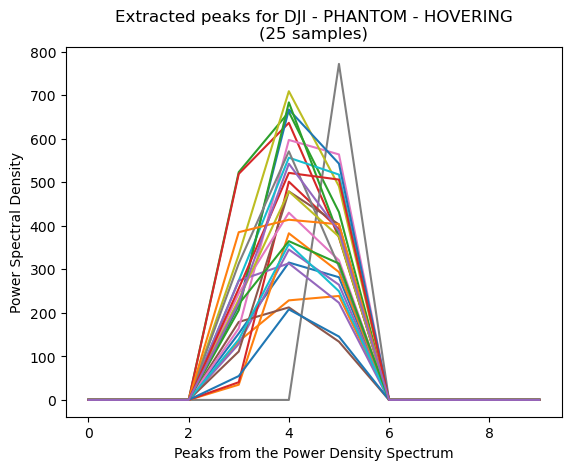

In [148]:
# aggregation_to_plot = "make_model"
aggregation_to_plot = "make_model_activity"

print(working_df[aggregation_to_plot].value_counts())

for agg in working_df[aggregation_to_plot].value_counts().index:

    series = working_df.peaks_pds[working_df[aggregation_to_plot] == agg]

    for row in series:
        plt.plot(row)
    
    print("peaks of " + agg)
    plt.xlabel('Peaks from the Power Density Spectrum')
    plt.ylabel('Power Spectral Density')
    plt.title(f'Extracted peaks for {agg}\n({len(series)} samples)')
    plt.show()


# Modelling

## Decision Tree from sklearn

### Train-Test split

In [105]:
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(nlos_df, test_size=0.2, stratify=nlos_df['make_model'], random_state=42)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

Train samples NLOS: (48, 10)
Test samples NLOS: (12, 10)


In [104]:
# Split the samples for LOS

train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

Train samples LOS: (160, 10)
Test samples LOS: (40, 10)


In [115]:
# Concat LOS and NLOS
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)
test_df

# select only needed columns
sel_col = ['make_model', 'peaks_pds']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

list

### Expand peak list to columns for different features

In [ ]:
# Expand the columns to make features

def expand_list_column(df, list_col, new_cols):
    """
    Expand a column containing lists into multiple new columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    list_col (str): The name of the column containing lists.
    new_cols (list): A list of new column names.
    
    Returns:
    pd.DataFrame: The DataFrame with new columns.
    """
    # Check if the length of new_cols matches the length of the lists in list_col
    if df[list_col].apply(len).max() > len(new_cols):
        raise ValueError("The number of new columns must be at least as many as the longest list in the column.")
    
    # Create new columns
    for i, col_name in enumerate(new_cols):
        df[col_name] = df[list_col].apply(lambda x: x[i] if i < len(x) else None)
    
    return df

# New column names
new_columns = ['peak_1_pds', 'peak_2_pds', 'peak_3_pds', 'peak_4_pds', 'peak_5_pds', 
               'peak_6_pds', 'peak_7_pds', 'peak_8_pds', 'peak_9_pds', 'peak_10_pds', ]

# Apply the function to the DataFrame
train_df_expanded = expand_list_column(train_df, 'peaks_pds', new_columns)
test_df_expanded = expand_list_column(test_df, 'peaks_pds', new_columns)

# Now drop peaks_pds
train_df_expanded.drop(columns="peaks_pds", inplace=True)
test_df_expanded.drop(columns="peaks_pds", inplace=True)


In [128]:
print("Train samples:", train_df_expanded.shape)
print("Test samples:", test_df_expanded.shape)

train_df_expanded.head()

Train samples: (208, 11)
Test samples: (52, 11)


,make_model,peak_1_pds,peak_2_pds,peak_3_pds,peak_4_pds,peak_5_pds,peak_6_pds,peak_7_pds,peak_8_pds,peak_9_pds,peak_10_pds
0,BEEBEERUN - FPV RC drone mini quadcopter,0,98.636836,50.565926,187.569196,0.0,0.0,0.0,979.565446,130.912853,75.455833
1,BEEBEERUN - FPV RC drone mini quadcopter,0,98.155591,51.221068,184.575316,0.0,0.0,0.0,903.472726,120.512585,81.991850
2,BEEBEERUN - FPV RC drone mini quadcopter,0,97.824351,54.041476,183.196277,0.0,0.0,0.0,866.651123,107.141898,82.984686
3,BEEBEERUN - FPV RC drone mini quadcopter,0,97.184186,52.064409,180.244157,0.0,0.0,0.0,898.601192,118.474898,81.997168
4,BEEBEERUN - FPV RC drone mini quadcopter,0,97.068546,48.884969,176.803736,0.0,0.0,0.0,913.895498,123.229681,80.658196


### Run the model

In [131]:
# Convert string labels to numerical values
label_encoder = LabelEncoder()
train_df['make_model'] = label_encoder.fit_transform(train_df['make_model'])
test_df['make_model'] = label_encoder.transform(test_df['make_model'])

# Split the data into features and target
X_train = train_df.drop('make_model', axis=1)
y_train = train_df['make_model']
X_test = test_df.drop('make_model', axis=1)
y_test = test_df['make_model']

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.75
Classification Report:
                                          precision    recall  f1-score   support

BEEBEERUN - FPV RC drone mini quadcopter       1.00      1.00      1.00         5
                           DJI - INSPIRE       0.67      0.86      0.75        14
                              DJI - M600       0.86      0.67      0.75         9
                          DJI - MAVICPRO       1.00      0.90      0.95        10
                           DJI - PHANTOM       0.54      0.50      0.52        14

                                accuracy                           0.75        52
                               macro avg       0.81      0.78      0.79        52
                            weighted avg       0.76      0.75      0.75        52



### Confusion Matrices

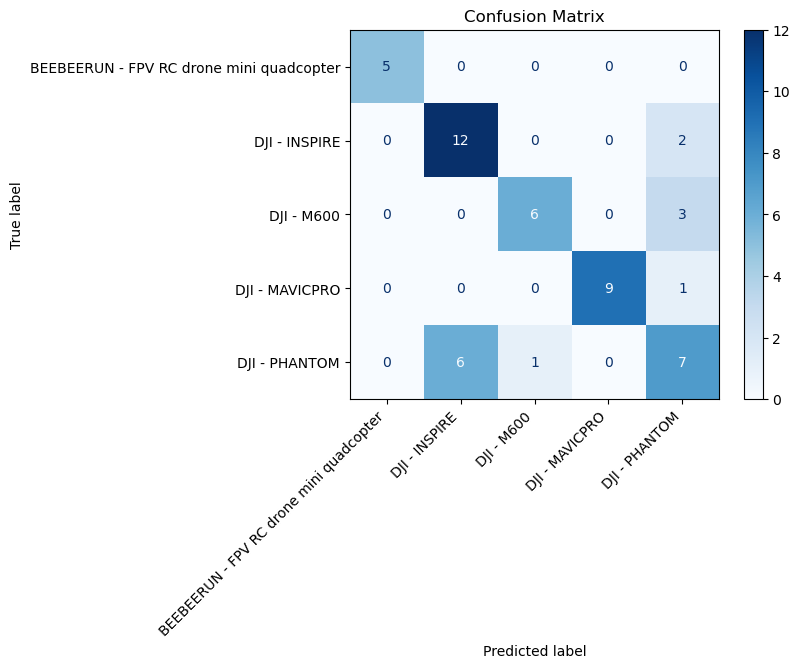

In [139]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

Accuracy: 0.9855769230769231
Classification Report:
                                          precision    recall  f1-score   support

BEEBEERUN - FPV RC drone mini quadcopter       1.00      1.00      1.00        20
                           DJI - INSPIRE       0.95      1.00      0.97        56
                              DJI - M600       1.00      0.94      0.97        36
                          DJI - MAVICPRO       1.00      1.00      1.00        40
                           DJI - PHANTOM       1.00      0.98      0.99        56

                                accuracy                           0.99       208
                               macro avg       0.99      0.99      0.99       208
                            weighted avg       0.99      0.99      0.99       208



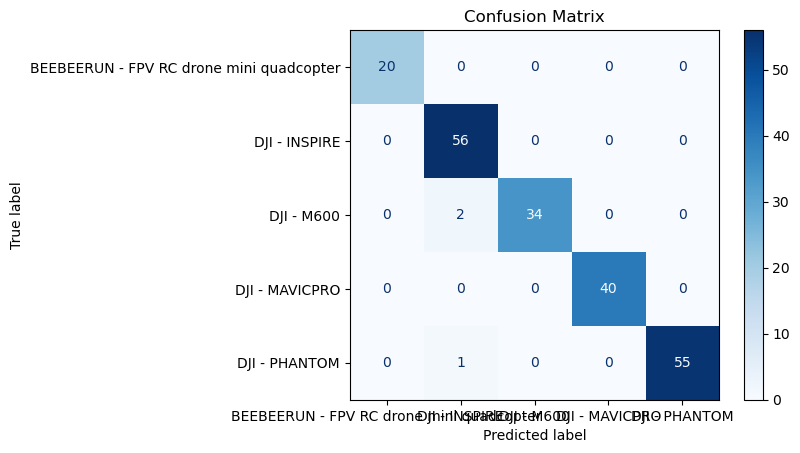

In [137]:
# Make predictions on the train set
y_pred_train = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

### Display the tree

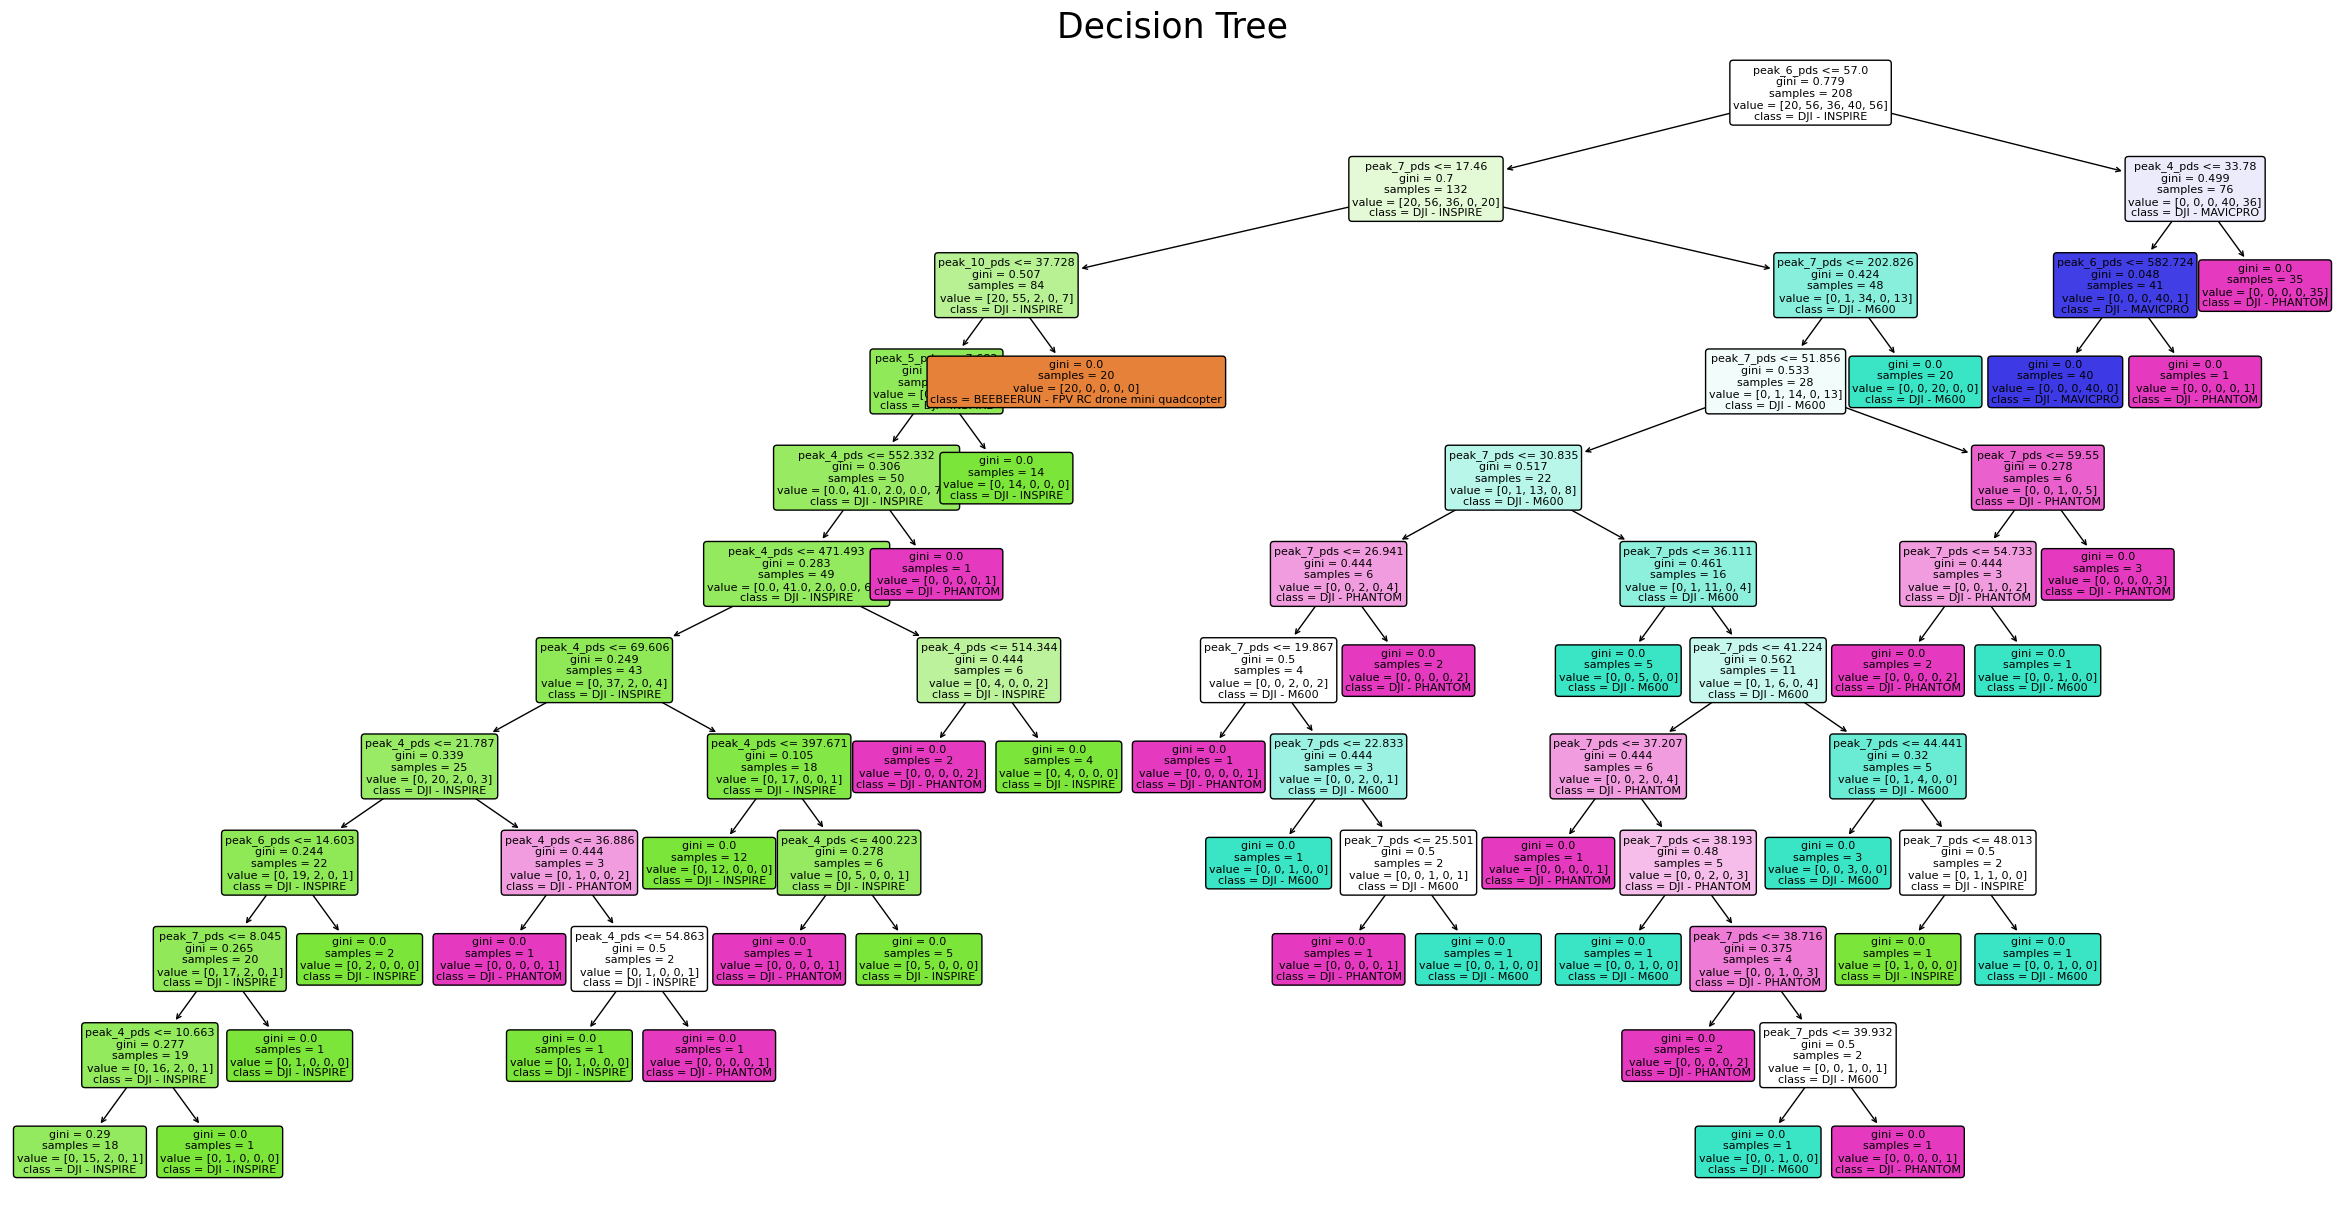

In [161]:
# Visualize the decision tree
plt.figure(figsize=(30, 15))
plot_tree(clf, feature_names=X_train.columns, class_names=label_encoder.classes_, filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree', fontsize=25)
plt.show()

# OLD


### NumPy

In [5]:
"""
Using numpy to load the data
"""

file = "BEEBEERUN_0000100002.mat_data.csv"
# file = 'MAVICPRO_10M_HOVERING00012.mat_data.csv'

tic = time.time()
# Load the CSV file using numpy, only reading the "Data" column
data = np.genfromtxt(beebeerun_path+file, delimiter=',', skip_header=1, usecols=[0], dtype=float)
# data = np.genfromtxt(dji_path+file, delimiter=',', skip_header=1, usecols=[0], dtype=float)

# Scale to get voltage
data = data * 6.581**(-6)

tac = time.time()
execution_time = tac - tic
print(f"Execution time: {execution_time:.4f} seconds")
print("Length of data:", len(data))

start, num_values, step = 0, 5000000, 0.25
x_values = np.linspace(start, start + step * (num_values - 1), num_values)

Execution time: 9.2216 seconds
Length of data: 5000000


In [6]:
# Take each n-th value
data_5 = data[::5]
x_values_5 = x_values[::5]
data_10 = data[::10]
x_values_10 = x_values[::10]
data_100 = data[::100]
x_values_100 = x_values[::100]

In [7]:
pd.DataFrame({"x":x_values_100, "y": data_100}).to_csv(
    "CardRF_signal_example_2.csv", sep=",", index_label=False) 

In [ ]:
from statsmodels.tsa.stattools import adfuller
signal_adj = data[:1000000]
# Perform the ADF test
result = adfuller(signal_adj)

# Print the ADF test results
print('Augmented Dickey-Fuller Test:')
print('Test Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] < 0.05:
    print('The time series is stationary.')
else:
    print('The time series is non-stationary.')

### CuPy

In [ ]:
"""
Using cupy with GPU to load the data
"""

# Verify and set the CUDA path
cuda_path = "C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.5/bin"
if cuda_path not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + cuda_path

In [11]:
file = "BEEBEERUN_0000100002.mat_data.csv"

tic = time.time()
# Load the CSV file using numpy, only reading the "Data" column
data = cp.genfromtxt( beebeerun_path+file , delimiter=',', skip_header=1, usecols=[0], dtype=cp.float32)

# Ensure data contains only numeric values by filtering out NaNs
data = data[~cp.isnan(data)]

tac = time.time()
execution_time = tac - tic
print(f"Execution time: {execution_time:.4f} seconds")

# Print the first 10 elements to verify
print(data[:10].get())

Execution time: 11.7920 seconds
[-1644. -1208. -1032.  -924.  -688.  -828. -1328. -1564. -1532. -1464.]


## Visualize

### Matplotlib

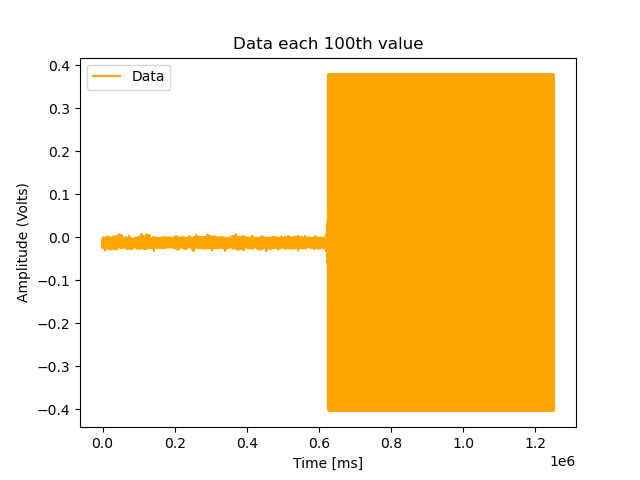

In [6]:
# Using matplotlib interactive widget

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the data
# ax.plot(data_5, label='Data', color="blue")
ax.plot(x_values_100, data_100, label='Data', color="orange")

# Customize the plot
ax.set_title('Data each 100th value')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Amplitude (Volts)')
ax.legend()

# Show the plot
plt.show()

## Fourier Transform

In [8]:
from scipy.signal import stft

sampling_rate = 0.025 # 0.25ms for 5 million, each 100 => 25ms => 0.025s

f, t, Zxx = stft(data_100, fs=sampling_rate, nperseg=256, noverlap=128)

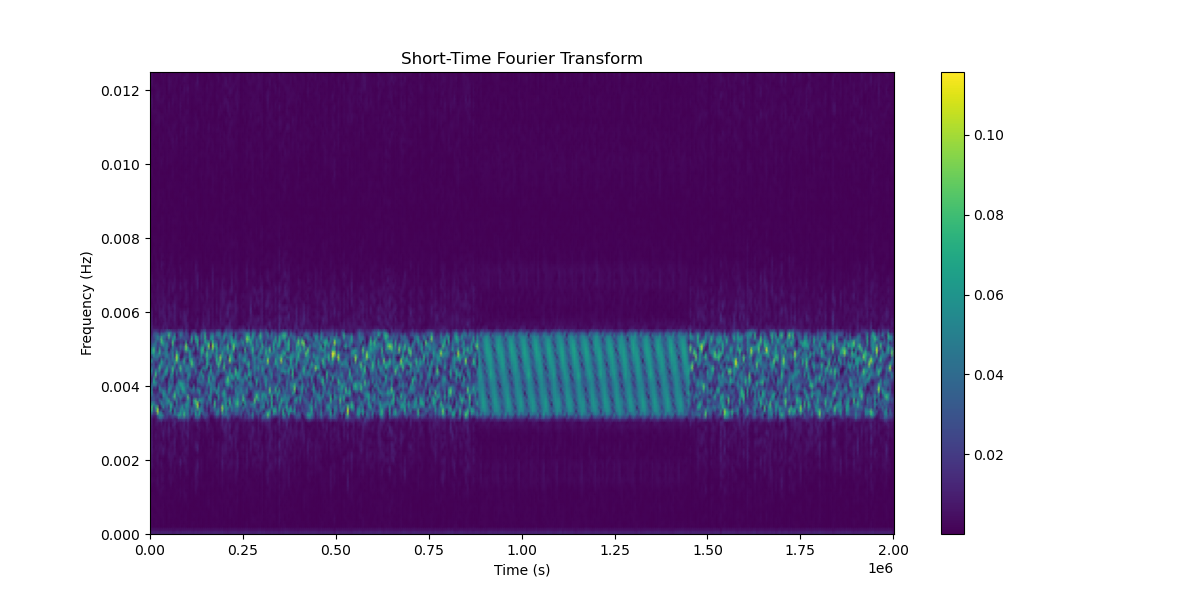

In [28]:
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Short-Time Fourier Transform')
plt.colorbar()
plt.show()

# Understanding Fourier

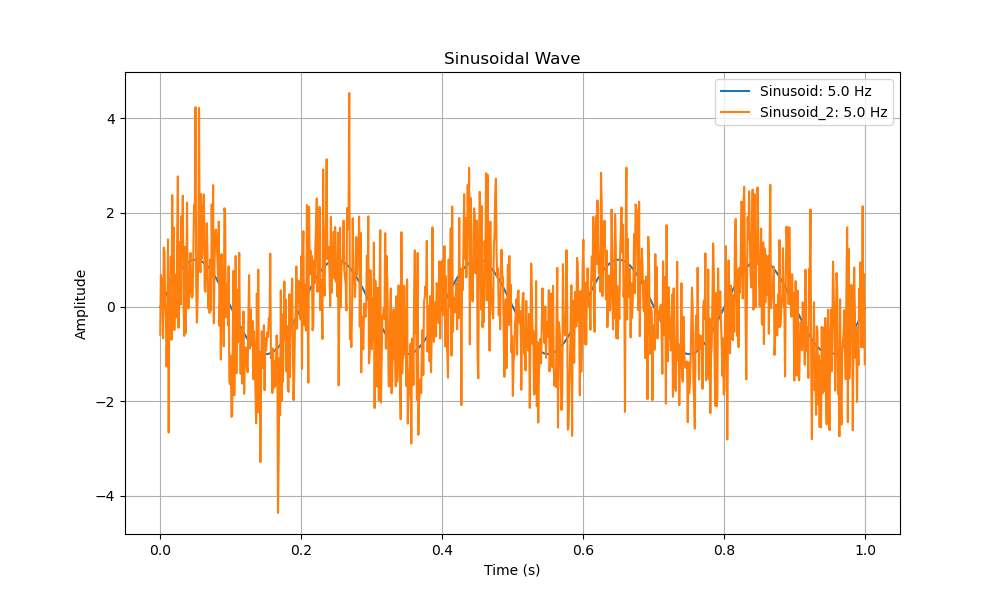

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the sinusoid
amplitude = 1.0
frequency = 5.0  # in Hz
phase = 0.0      # in radians
sampling_rate = 1000  # in Hz
duration = 1.0   # in seconds

# Generate the time values
time = np.arange(0, duration, 1/sampling_rate)

# Generate the sinusoidal signal
signal = amplitude * np.sin(2 * np.pi * frequency * time + phase) 
signal_2 = amplitude * np.sin(2 * np.pi * frequency * time + phase) + np.random.randn(len(time))



# Plot the sinusoidal signal
plt.figure(figsize=(10, 6))
plt.plot(time, signal, label=f'Sinusoid: {frequency} Hz')
plt.plot(time, signal_2, label=f'Sinusoid_2: {frequency} Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sinusoidal Wave')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Viktor\AppData\Local\Temp\ipykernel_8828\4269458840.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


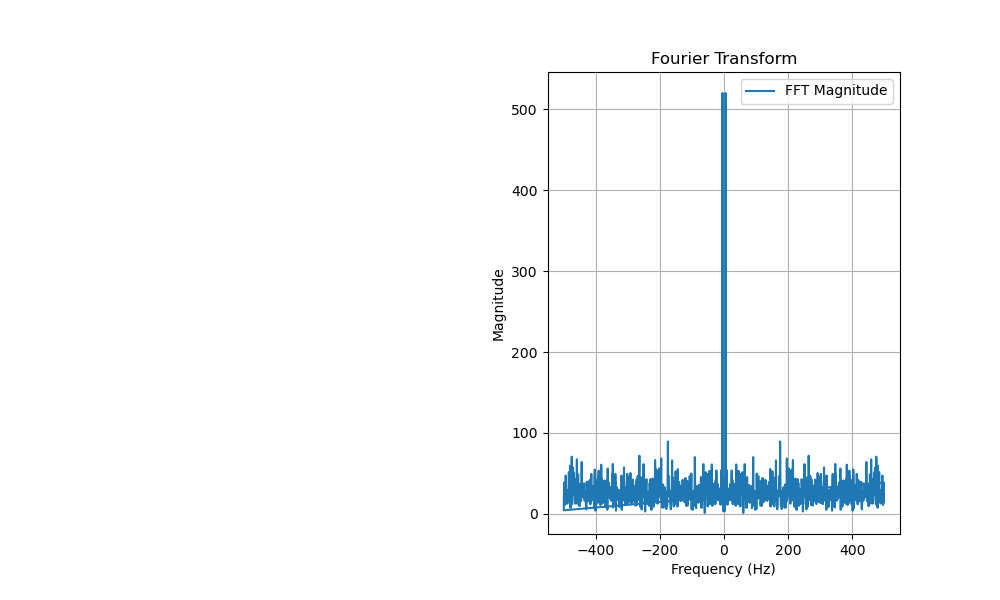

In [34]:
# Perform FFT
fft_result = np.fft.fft(signal_2)
frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)
magnitude_spectrum = np.abs(fft_result)

# Plot the magnitude of the Fourier transform
plt.subplot(1, 2, 2)
plt.plot(frequencies, magnitude_spectrum, label='FFT Magnitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.legend()
plt.grid(True)


plt.show()

# Other

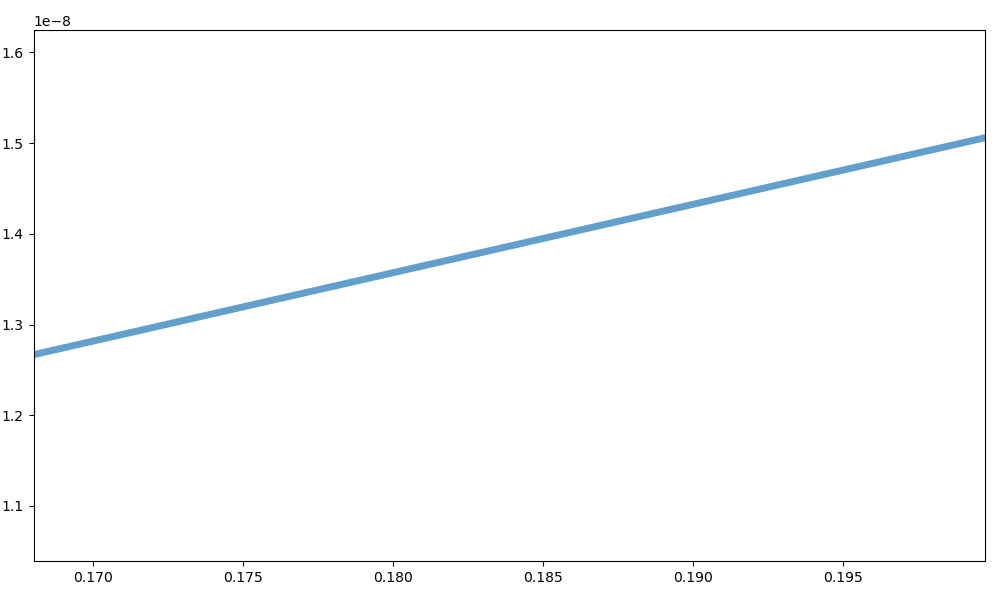

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# define frequencies, amplitudes, and sampling rate and time array:
f1 =  2  # Frequency 1 in Hz
f2 = 10  # Frequency 2 in Hz
A1 = 6   # Amplitude 1
A2 = 2   # Amplitude 2
# Fs = 20e9 # Sampling rate (20 GSa/s)
FS = 10
t  = np.arange(0,1e-9,1/Fs) # Time array in nanoseconds

# calculate prime signals:
A_sin = A1 * np.sin(2 )
plt.plot(A_sin)
# A_cos = A2 * np.cos(2 * np.pi * f2 * t)
# A_signal = A_sin + A_cos

# # add some noise:
# np.random.seed(1)
# A_Noise = 2
# Noise = np.random.randn(len(t)) * A_Noise
# A_signal_noisy = A_signal + Noise

# # plots:
# fig=plt.figure(3, figsize=(9,4))
# plt.clf()
# plt.plot(t*1e9, A_sin, label="sine", lw=5, alpha=0.7) # Time in ns
# plt.plot(t*1e9, A_cos, label="cosine", lw=5, alpha=0.7)
# plt.plot(t*1e9, A_signal, lw=5, c="mediumorchid", 
#          label="superposition", alpha=0.75)
# plt.plot(t*1e9, A_signal_noisy, lw=5, c="lime", 
#          label="superposition + noise", alpha=0.5)
# plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
# plt.xticks([0, 0.25e-9, 0.5e-9, 0.75e-9, 1e-9], 
#            ["0", r"$\frac{\pi}{2}$", r"$\pi$", 
#             r"$\frac{3}{4}\pi$", r"$2\pi$"])
# plt.xlabel("Time (ns)")
# plt.tight_layout()
plt.show()


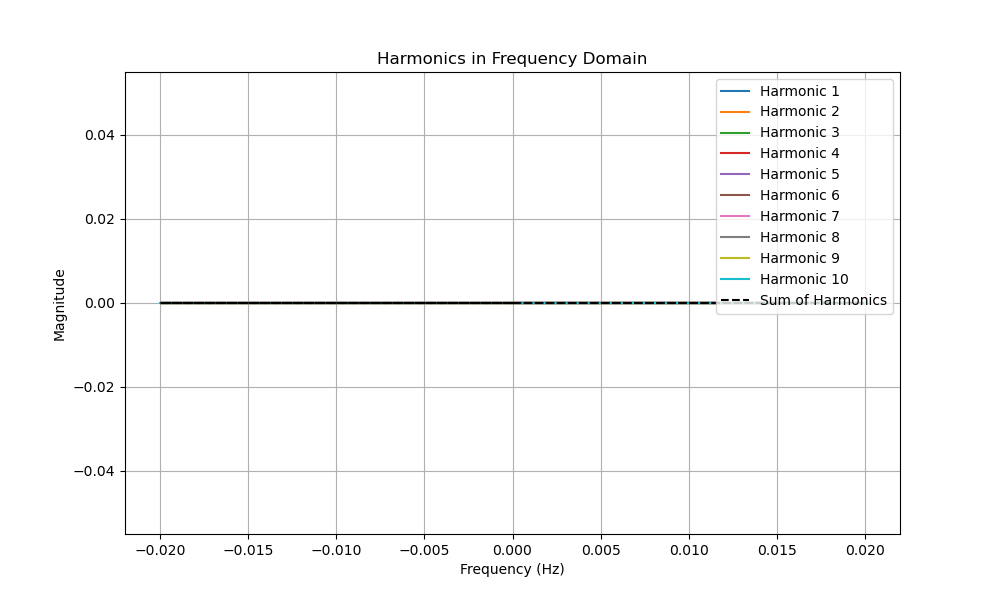

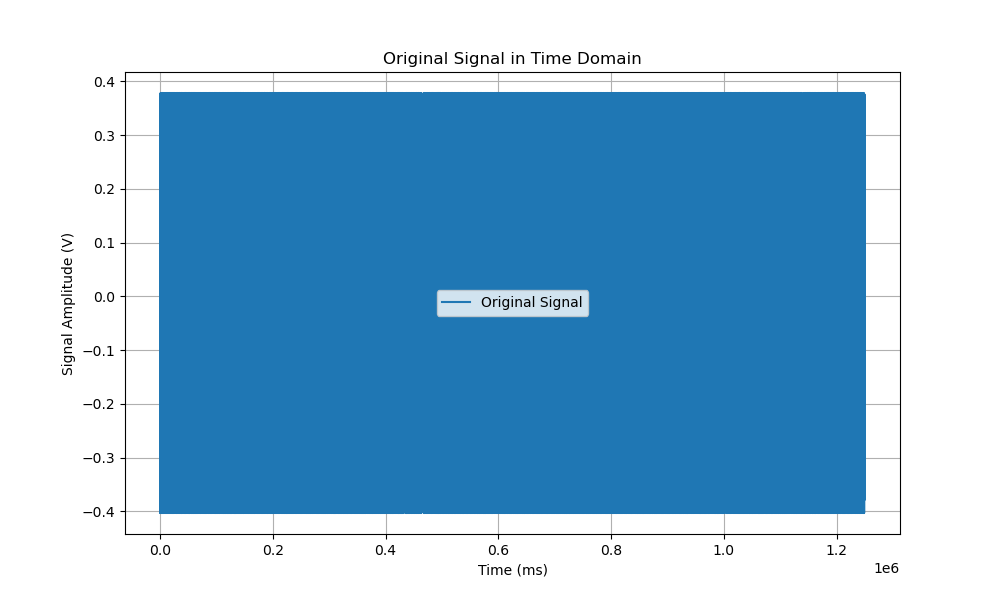

In [14]:
# Assuming time and signal data are already defined
time = x_values_100
signal = data_100

n_harmonics = 10

# Perform FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=(time[1] - time[0]))

# Extract the magnitudes
magnitude_spectrum = np.abs(fft_result)

# Initialize list to store the harmonic signals
harmonics = []

# Loop to extract each harmonic
for i in range(1, n_harmonics + 1):
    harmonic = np.zeros_like(fft_result)
    harmonic[(frequencies > (i - 0.5)) & (frequencies < (i + 0.5))] = fft_result[(frequencies > (i - 0.5)) & (frequencies < (i + 0.5))]
    harmonics.append(harmonic)

# Plot the harmonics in the frequency domain
plt.figure(figsize=(10, 6))
for i, harmonic in enumerate(harmonics):
    magnitude = np.abs(harmonic)
    plt.plot(frequencies, magnitude, label=f'Harmonic {i+1}')
    
# Plot the sum of harmonics
sum_of_harmonics = np.sum([np.abs(h) for h in harmonics], axis=0)
plt.plot(frequencies, sum_of_harmonics, label="Sum of Harmonics", linestyle='--', color='black')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Harmonics in Frequency Domain')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original signal
plt.figure(figsize=(10, 6))
plt.plot(time, signal, label="Original Signal")
plt.xlabel('Time (ms)')
plt.ylabel('Signal Amplitude (V)')
plt.title('Original Signal in Time Domain')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# Compute magnitudes of Fourier coefficients (considering only positive frequencies)
fft_mags = np.abs(all_coeffs[:len(all_coeffs) // 2 + 1])  # Magnitudes up to Nyquist frequency

# Optionally, use squared magnitudes to emphasize strong components
fft_features = np.square(fft_mags)

# Create a DataFrame from fft_features
df_fft = pd.DataFrame(fft_features)

# Display the DataFrame
print("DataFrame showing Fourier coefficients (features):")
print(df_fft.head())  # Display the first few rows for illustration

DataFrame showing Fourier coefficients (features):
              0
0  3.003925e-15
1  9.596226e-15
2  4.505290e-18
3  1.259077e-15
4  3.393510e-18


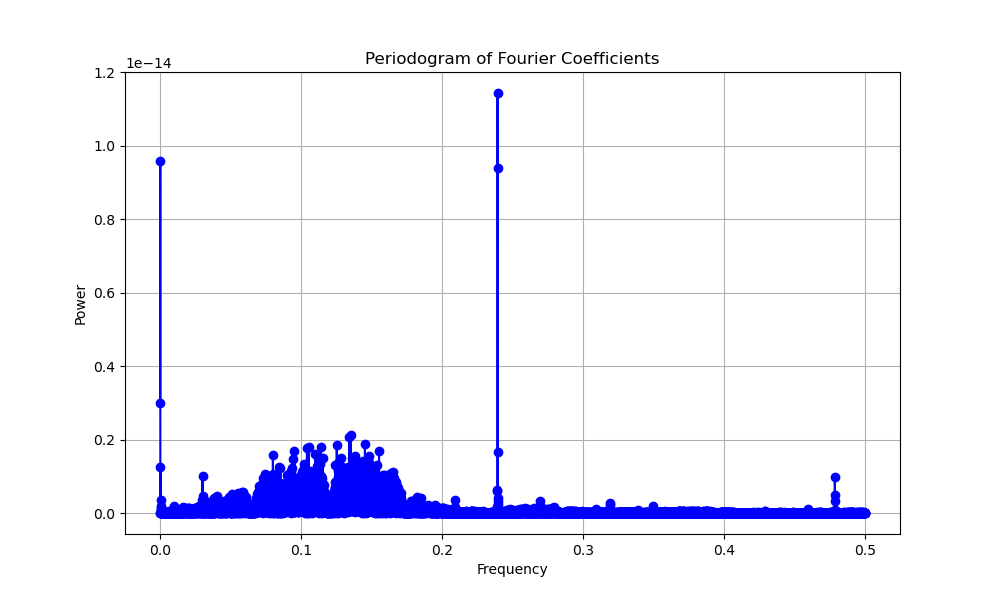

In [55]:
N = len(fft_features)
freqs = np.fft.fftfreq(N)  # Frequencies corresponding to the coefficients
periodogram = fft_features[:N//2 + 1]  # Take half + 1 due to symmetry

# Plot the periodogram (optional but helpful for visualization)
plt.figure(figsize=(10, 6))
plt.plot(freqs[:N//2 + 1], periodogram, marker='o', linestyle='-', color='b')
plt.title('Periodogram of Fourier Coefficients')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()